# Setup for the model training and usage

In [1]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Setup base directories
BASE_DIR = os.path.abspath("..")
DATA_DIRS = [
    os.path.join(BASE_DIR, "data/IDD_Segmentation/IDD_Segmentation"),
    os.path.join(BASE_DIR, "data/IDD_Segmentation/idd20kII")
]
MODELS_DIR = os.path.join(BASE_DIR, "models")
UTILS_DIR = os.path.join(BASE_DIR, "utils")

# Add directories to path
sys.path.append(MODELS_DIR)
sys.path.append(UTILS_DIR)

# Model creation and training

In [ ]:
from attention_unet import attention_unet
from data_generator import IDDSegmentationGenerator
from tensorflow.keras.models import load_model
from tqdm import tqdm

MODEL_PATH = os.path.join(BASE_DIR, "attention_unet_model.h5")


image_paths = []
mask_paths = []

for data_root in DATA_DIRS:
    img_root = os.path.join(data_root, "leftImg8bit/train")
    mask_root = os.path.join(data_root, "gtFine/train")

    cities = os.listdir(img_root)
    for city in tqdm(cities, desc=f"Processing {data_root}"):
        img_dir = os.path.join(img_root, city)
        msk_dir = os.path.join(mask_root, city)

        img_files = glob.glob(os.path.join(img_dir, "*_leftImg8bit.png"))
        for img_path in img_files:
            base = os.path.basename(img_path).replace("_leftImg8bit.png", "")
            mask_path = os.path.join(msk_dir, base + "_gtFine_labelLevel3Ids.png")

            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)

train_img, val_img, train_mask, val_mask = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_gen = IDDSegmentationGenerator(train_img, train_mask, batch_size=8)
val_gen = IDDSegmentationGenerator(val_img, val_mask, batch_size=8)

if os.path.exists(MODEL_PATH):
    print("Found existing model. Loading...")
    model = load_model(MODEL_PATH, compile=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Model load complete")
else:
    print("No saved model found. Training the model...")
    model = attention_unet(input_shape=(256, 256, 3), num_classes=27)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_gen, validation_data=val_gen, epochs=20)
    model.save(MODEL_PATH)
    print("Model saved to disk at",MODEL_PATH)



# Evaluation

In [ ]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


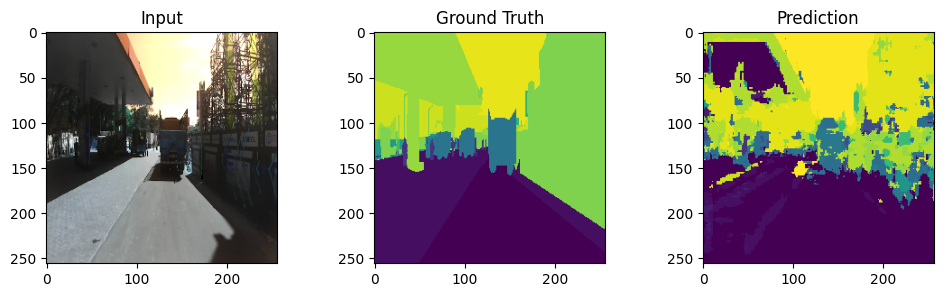

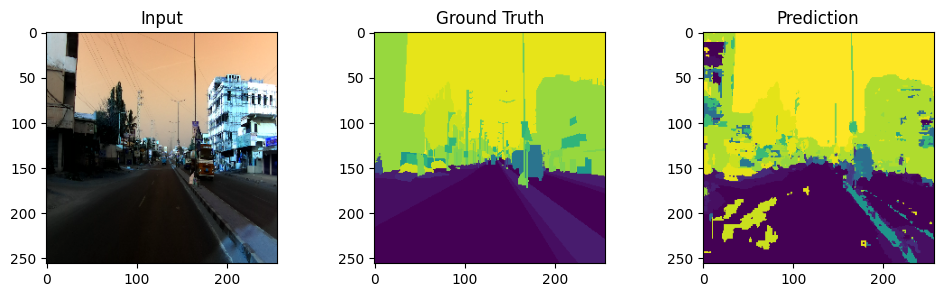

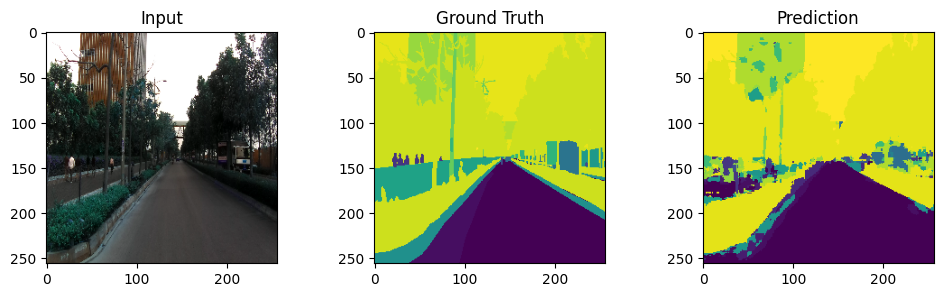

In [5]:
sample_images, sample_masks = val_gen[0]
preds = model.predict(sample_images)
pred_labels = np.argmax(preds, axis=-1)
true_labels = np.argmax(sample_masks, axis=-1)

for i in range(3):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1); plt.imshow(sample_images[i]); plt.title("Input")
    plt.subplot(1, 3, 2); plt.imshow(true_labels[i]); plt.title("Ground Truth")
    plt.subplot(1, 3, 3); plt.imshow(pred_labels[i]); plt.title("Prediction")
    plt.show()
